In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [2]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
high_img = []
path = '/Users/aviral/Documents/programming/datas/Lowtohigh/Faces/high_image'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.jpg': 
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))


low_img = []
path = '/Users/aviral/Documents/programming/datas/Lowtohigh/Faces/low_image'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '855.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

 14%|█▍        | 119/840 [00:02<00:15, 46.40it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 37%|███▋      | 310/840 [00:06<00:10, 48.81it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 39%|███▉      | 330/840 [00:07<00:11, 46.26it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 45%|████▌     | 381/840 [00:08<00:10, 42.05it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 49%|████▉     | 412/840 [00:09<00:09, 44.87it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 52%|█████▏    | 438/840 [00:09<00:08, 46.82it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 53%|█████▎    | 448/840 [00:10<00:08, 46.19it/s]libpng warning: iCCP: known incorrect sRGB pr

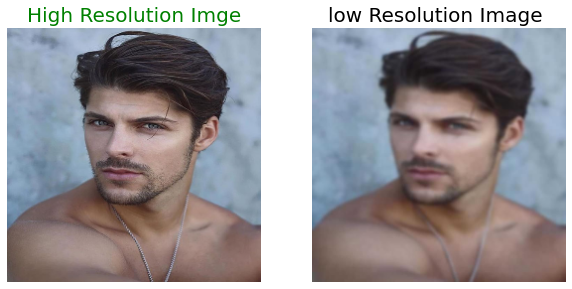

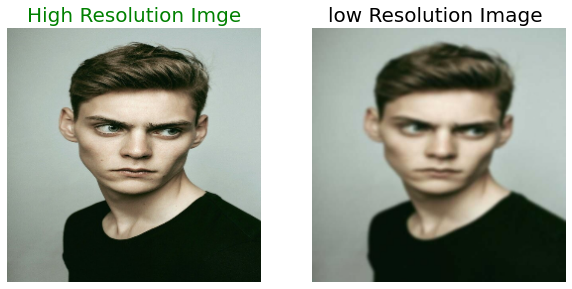

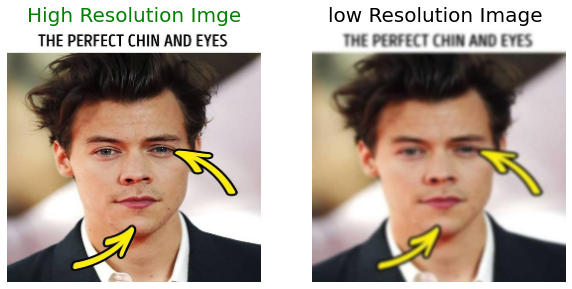

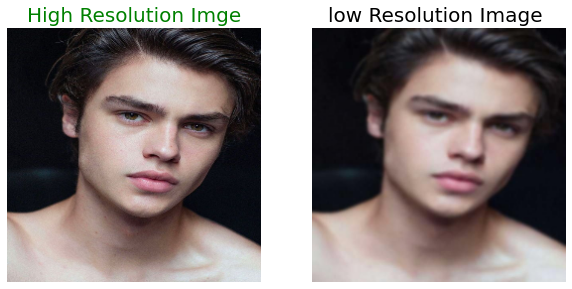

In [3]:
for i in range(4):
    a = np.random.randint(0,855)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')

In [4]:
train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:830]
validation_low_image = low_img[700:830]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[830:]
test_low_image = low_img[830:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (700, 256, 256, 3)
Shape of test images: (10, 256, 256, 3)
Shape of validation images: (130, 256, 256, 3)


In [5]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

def model():
    inputs = layers.Input(shape= [SIZE,SIZE,3])
    #downsampling
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 128)        3584      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 64, 64, 128)          147584    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 32, 32, 256)          296192    ['sequential_1[0][0]']        
                                                                                              

In [6]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

In [7]:
model.fit(train_low_image, train_high_image, epochs = 4, batch_size = 1,
          validation_data = (validation_low_image,validation_high_image))

Epoch 1/4
700/700 [==============================] - 223s 314ms/step - loss: 0.0322 - acc: 0.7749 - val_loss: 0.0239 - val_acc: 0.7832
Epoch 2/4
700/700 [==============================] - 342s 489ms/step - loss: 0.0221 - acc: 0.8135 - val_loss: 0.0196 - val_acc: 0.8104
Epoch 3/4
700/700 [==============================] - 150s 215ms/step - loss: 0.0206 - acc: 0.8184 - val_loss: 0.0199 - val_acc: 0.8738
Epoch 4/4
700/700 [==============================] - 79s 113ms/step - loss: 0.0197 - acc: 0.8280 - val_loss: 0.0275 - val_acc: 0.8118


1/1 [==============================] - 0s 157ms/step


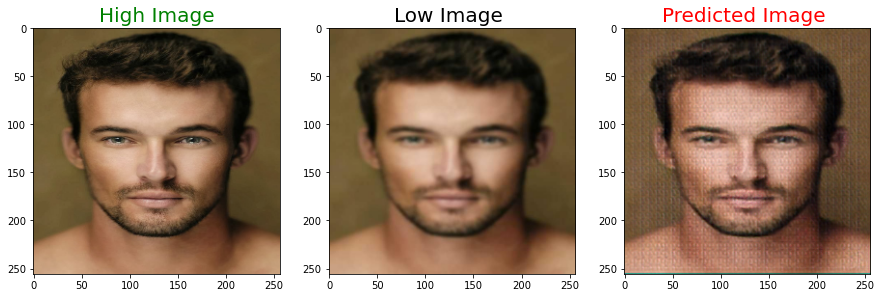

1/1 [==============================] - 0s 50ms/step


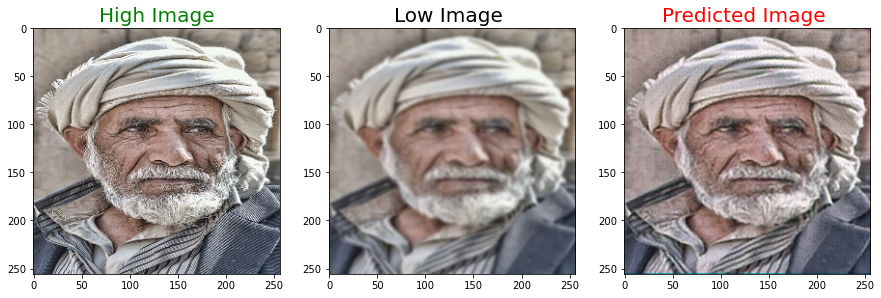

1/1 [==============================] - 0s 52ms/step


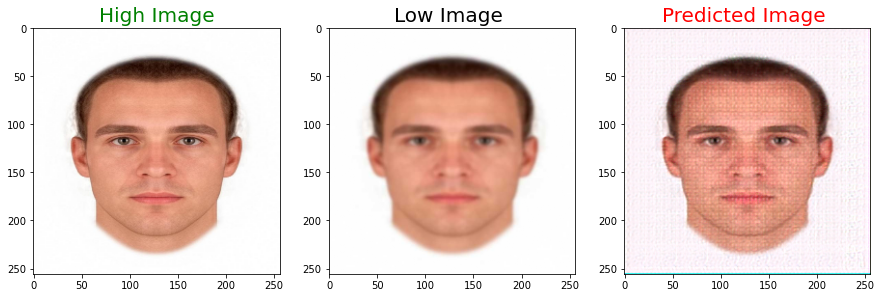

1/1 [==============================] - 0s 53ms/step


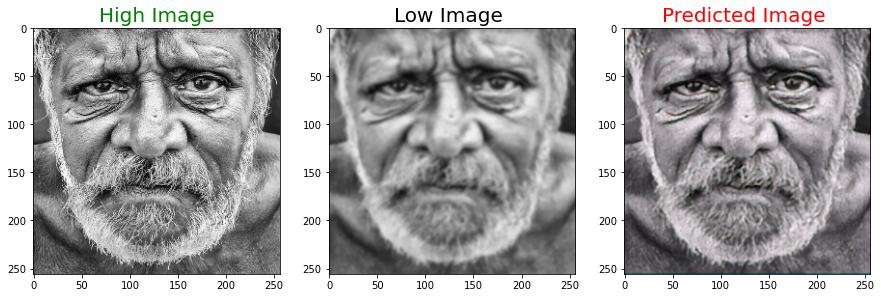

1/1 [==============================] - 0s 57ms/step


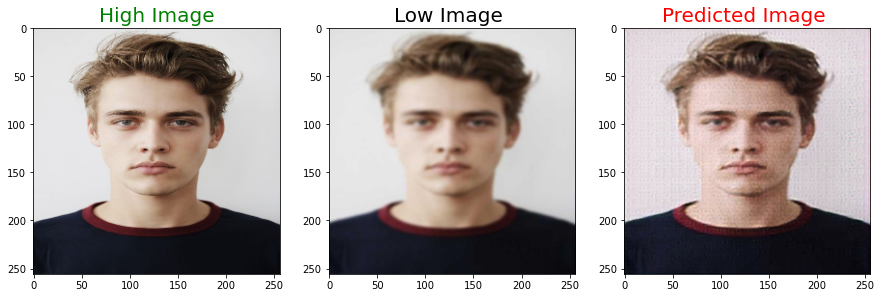

1/1 [==============================] - 0s 64ms/step


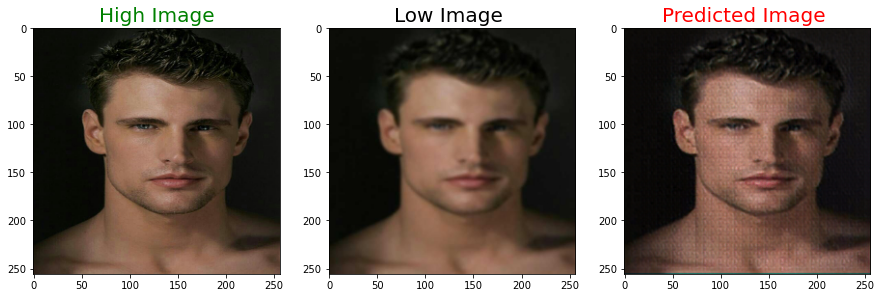

1/1 [==============================] - 0s 53ms/step


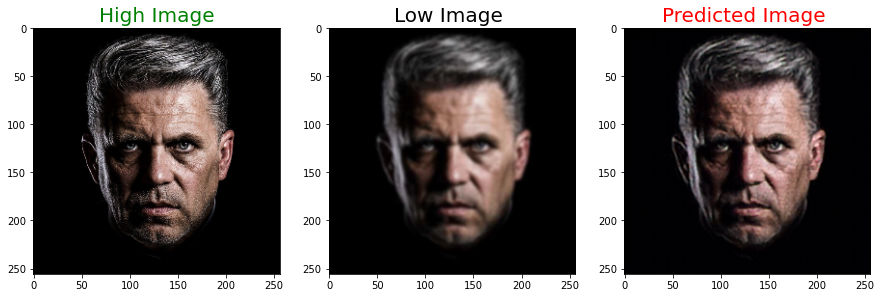

1/1 [==============================] - 0s 52ms/step


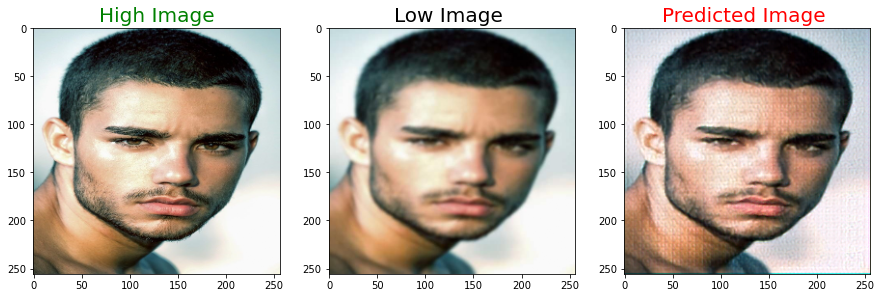

1/1 [==============================] - 0s 55ms/step


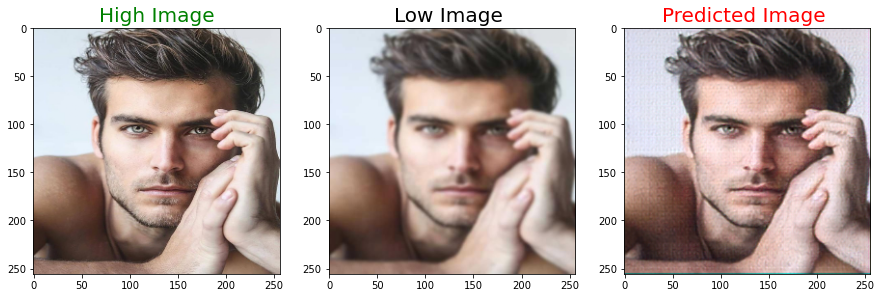

In [8]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(1,10):
    
    predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],test_low_image[i],predicted)

In [9]:
model.save("lowtohigh_model.sav")

FailedPreconditionError: lowtohigh_model.sav is not a directory

In [ ]:
"""
SIZE = 256

high_img = []
path = '/Users/aviral/Documents/programming/datas/Lowtohigh/Raw Data/high_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.jpg': 
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))

low_pred_img = []
path = '/Users/aviral/Documents/programming/datas/Lowtohigh/val/low_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '855.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_pred_img.append(img_to_array(img))"""

"\nSIZE = 256\n\nhigh_img = []\npath = '/Users/aviral/Documents/programming/datas/Lowtohigh/Raw Data/high_res'\nfiles = os.listdir(path)\nfiles = sorted_alphanumeric(files)\nfor i in tqdm(files):    \n    if i == '855.jpg': \n        break\n    else:    \n        img = cv2.imread(path + '/'+i,1)\n        # open cv reads images in BGR format so we have to convert it to RGB\n        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n        #resizing image\n        img = cv2.resize(img, (SIZE, SIZE))\n        img = img.astype('float32') / 255.0\n        high_img.append(img_to_array(img))\n\nlow_pred_img = []\npath = '/Users/aviral/Documents/programming/datas/Lowtohigh/val/low_res'\nfiles = os.listdir(path)\nfiles = sorted_alphanumeric(files)\nfor i in tqdm(files):\n     if i == '855.jpg':\n        break\n     else: \n        img = cv2.imread(path + '/'+i,1)\n        # open cv reads images in BGR format so we have to convert it to RGB\n        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n        

In [ ]:
"""for i in range(4):
    a = np.random.randint(0,30)
    plt.figure(figsize=(10,10))
    
    plt.subplot(1,2,2)
    plt.title('low Resolution Validation Image ', color = 'black', fontsize = 20)
    plt.imshow(low_pred_img[a])
    plt.axis('off')"""

"for i in range(4):\n    a = np.random.randint(0,30)\n    plt.figure(figsize=(10,10))\n    \n    plt.subplot(1,2,2)\n    plt.title('low Resolution Validation Image ', color = 'black', fontsize = 20)\n    plt.imshow(low_pred_img[a])\n    plt.axis('off')"

In [ ]:
"""def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(1,10):
    
    predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],test_low_image[i],predicted)"""

"def plot_images(high,low,predicted):\n    plt.figure(figsize=(15,15))\n    plt.subplot(1,3,1)\n    plt.title('High Image', color = 'green', fontsize = 20)\n    plt.imshow(high)\n    plt.subplot(1,3,2)\n    plt.title('Low Image ', color = 'black', fontsize = 20)\n    plt.imshow(low)\n    plt.subplot(1,3,3)\n    plt.title('Predicted Image ', color = 'Red', fontsize = 20)\n    plt.imshow(predicted)\n   \n    plt.show()\n\nfor i in range(1,10):\n    \n    predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)\n    plot_images(test_high_image[i],test_low_image[i],predicted)"